In [2]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pathlib
import warnings
import yaml

import matplotlib.patches as mpatches
import matplotlib

# Set font settings
plt.rcParams['svg.fonttype'] = 'none'  # Keep text editable
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'Liberation Sans', 'DejaVu Sans']


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

_LATENT = "latent"
_X_UMAP = "X_umap"

_BIO_CONSERVATION = "Bio_conservation"
_BATCH_INTEGRATION = "Batch_integration"


_BIO_LABEL = "Bio-conservation"
_BATCH_LABEL = "Batch correction"

_BIO_COLS = ["ARI", "NMI", "clisi", "graph_connect"]
_BATCH_COLS = ["kbet_per_label", "ilisis"]

_fontsize = 17
fontdict = {"fontsize": _fontsize}


In [3]:

figure_config = yaml.safe_load(open("figures_config.yml", "r"))
datasets = figure_config["datasets"]
methods = figure_config["methods"]
method_order = sorted(['bbknn',
 'harmony',
 'scvi',
 'cca',
 "mnc",
 'ldvae',
 'rpca',
 'combat',
 'scanorama',
 'dhaka',
"unintegrated"], key=lambda x: figure_config["method_order"].index(methods[x]))
method_colors = figure_config["method_colormap"]
methods_map = figure_config["methods"]

In [4]:
dataset_map = {
 'neftel_ss': 'Neftel, SS2',
 'neftel_10x': 'Neftel, 10X',
 'kim_lung': 'Kim',
 'ji_skin': 'Ji',
}

### Plot umaps

In [5]:
def add_title(ax, title, color):
    rect = patches.Rectangle((-0.1, 1.), 1.2, patch_height, fill=True, 
                                 transform=ax.transAxes, facecolor=color, edgecolor='none', clip_on=False)
    ax.add_patch(rect)
    ax.text(0.5, 1.+(patch_height/2), title, ha='center', va='center', transform=ax.transAxes,
            fontsize=24)

def umap_axes(ax):
    ax_mini = ax.inset_axes([0.00, 0.00, 0.25, 0.25])
    ax_mini.patch.set_alpha(0)
    ax_mini.set_xlim(ax.get_xlim())
    ax_mini.set_ylim(ax.get_ylim())
    ax.set_axis_off()
    # Style the mini axes
    ax_mini.tick_params(axis='both', colors='white', labelsize=8)
    for spine in ["left", "bottom", "right", "top"]:
        ax_mini.spines[spine].set_visible(False)
        
    
    # Add UMAP labels
    ax_mini.set_xlabel('     UMAP1', fontsize=18, labelpad=-10.)
    ax_mini.set_ylabel('     UMAP2', fontsize=18, labelpad=-10.)

    arrow_props = dict(arrowstyle='->', color='black', linewidth=2)
    ax_mini.annotate('', xy=(1.5, 0), xytext=(-0.05, 0), xycoords='axes fraction', 
                     arrowprops=arrow_props)
    ax_mini.annotate('', xy=(0, 1.5), xytext=(0, -0.05), xycoords='axes fraction', 
                     arrowprops=arrow_props)


def get_results(path: str) -> pd.DataFrame:
    rootdir = pathlib.Path(path)
    file_list = [f for f in rootdir.glob('**/*') if f.is_file()]
    
    clustering_results = []
    metrics_results = []
    for file in file_list:
        if file.stem == "cluster":
            idx = tuple(str(file).split("/")[4:-1])
            clustering_result = pd.read_csv(file, index_col=[0, 1])
            mean_clustering_result = clustering_result.mean(1)
            best_resolution = mean_clustering_result.groupby(level=1).mean().idxmax()
            clustering_best = mean_clustering_result.loc[mean_clustering_result.index.get_level_values(level=1)==best_resolution]
            clustering_best = pd.DataFrame(clustering_best.droplevel(1)).transpose()
            clustering_best.index = pd.MultiIndex.from_tuples([idx])
            clustering_results.append(clustering_best)
    
        else:
            idx = tuple(str(file).split("/")[4:-1])
            metric_result = pd.read_csv(file, index_col=0)
            metric_result.index = pd.MultiIndex.from_tuples([idx])
            metrics_results.append(metric_result)
    
    clustering_results = pd.concat(clustering_results, axis=0)
    metric_results = pd.concat(metrics_results, axis=0)
    
    results = pd.concat((clustering_results, metric_results), axis=1)

    return results

In [12]:
datasets = [path.stem.rsplit("_", 2)[0] for path in pathlib.Path("../integration/umap/data/preprocessed").iterdir() if path.name.endswith("all_0.h5ad")]

In [1]:

adata = sc.read_h5ad(f"../integration/debug/data/preprocessed/ji_skin.h5ad")
adata = adata[adata.obs["phase"]=="G1"].copy()
plotting_path = pathlib.Path(f"../integration/debug/plotting/ji_skin_all_0/4000/True")
methods_paths = [plotting_path.joinpath(method) for method in method_order]

fig, axes = plt.subplots(2, len(methods_paths), figsize=(24.5, 4.5))
patch_height = 0.2
for n_key, key in enumerate(["celltype", "sample"]):
    for n_ax, (ax, path) in enumerate(zip(axes[n_key, :], methods_paths)):

        umap = pd.read_csv(path.joinpath("umap.csv"), index_col=0)
        umap = umap.loc[adata.obs_names]
        adata.obsm[_X_UMAP] = umap.values

        legend_loc = "right margin" if n_ax == 10 else None
        palettes = None if n_key == 0 else "tab20b"
        title = methods[path.stem]
        method_color = method_colors[methods_map[path.stem]]
        sc.pl.umap(adata, color=key, ax=ax, show=False, title="", legend_loc=legend_loc, palette=palettes)
        if n_key == 0:
            add_title(ax, title, method_color)
        umap_axes(ax)

        
fig.tight_layout(w_pad=0.01)
fig.savefig(f"plots/{dataset}.png", dpi=500)


NameError: name 'sc' is not defined

In [21]:
method_order

['bbknn',
 'harmony',
 'combat',
 'scanorama',
 'cca',
 'scvi',
 'ldvae',
 'dhaka',
 'unintegrated']

### Benchmark plots

In [33]:
results = get_results("../results/benchmark/eval")

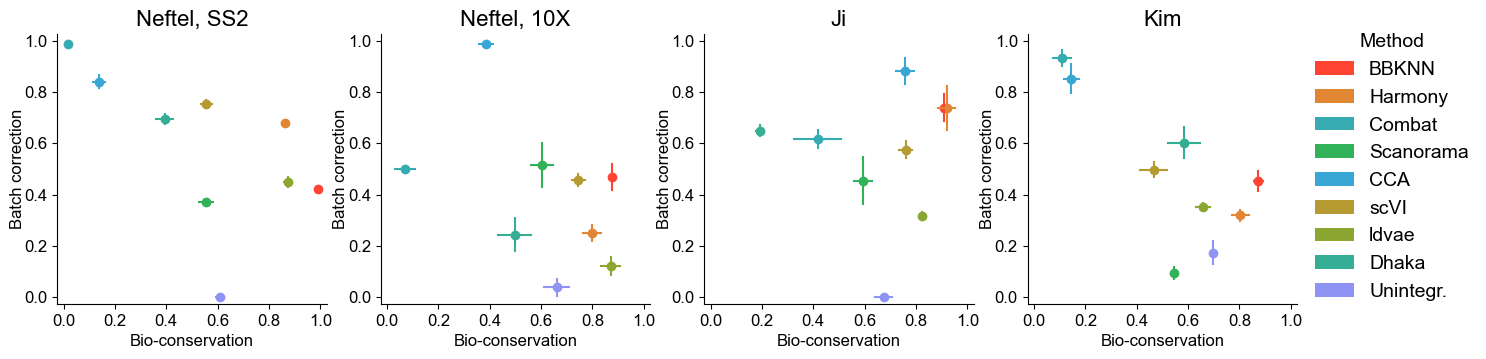

In [115]:
font_config = {
    'axes.titlesize': 16,          # Title font size
    'axes.labelsize': 12,          # X and Y label font size
    'legend.title_fontsize': 14,   # Legend title font size
    'legend.fontsize': 14,         # Legend text font size
    'xtick.labelsize': 12,         # X-axis tick labels font size
    'ytick.labelsize': 12,         # Y-axis tick labels font size
}



with plt.rc_context(font_config):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for dataset, ax in zip(datasets, axes.flatten()):
        subset = results.loc[dataset]
        cols = subset.columns
        g = subset.groupby(level=[0])[cols]
        min_, max_ = g.transform('min'), g.transform('max')
        subset.loc[:, cols] = (subset[cols] - min_) / (max_ - min_)
        subset=subset.droplevel(level=[0, 1, 2])
        subset[_BIO_CONSERVATION] = subset[_BIO_COLS].mean(1)
        subset[_BATCH_INTEGRATION] = subset[_BATCH_COLS].mean(1)
        subset = subset[[_BIO_CONSERVATION, _BATCH_INTEGRATION]]
        subset = subset.groupby(level=0).agg(['mean', 'sem'])
        subset.index = subset.index.map(methods_map)

        for method in method_order:
            method = methods_map[method]
            bio_mean, bio_sem, batch_mean ,batch_sem = subset.loc[method]
            ax.scatter(bio_mean, batch_mean, color=method_colors[method], label = method)
            ax.plot((bio_mean, bio_mean), (batch_mean+batch_sem, batch_mean-batch_sem), color=method_colors[method])
            ax.plot((bio_mean+bio_sem, bio_mean-bio_sem),(batch_mean, batch_mean),  color=method_colors[method])
            ax.set_xlabel(_BIO_LABEL)
            ax.set_ylabel(_BATCH_LABEL)
            ax.set_ylim((-0.025, 1.025))
            ax.set_xlim((-0.025, 1.025))
            ax.set_title(dataset_map[dataset])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_aspect('equal', adjustable='box')
            ax.yaxis.labelpad = -0.5

    handles = []
    for method in method_order:
        method = methods_map[method]
        handles.append(mpatches.Patch( facecolor=method_colors[method],label=method))

    legend = fig.legend(handles=handles, loc='center left', title="Method", bbox_to_anchor=(0.9, 0.5), frameon=False)
    #fig.tight_layout(w_pad=0.1)
    fig.savefig("figures/benchmark.svg")

### n_hvgs


In [125]:
results = get_results("../results/hvgs/eval/")

In [126]:
cols = results.columns
g = results.groupby(level=[0, 1])[cols]
min_, max_ = g.transform('min'), g.transform('max')
results[cols] = (results[cols] - min_) / (max_ - min_)

In [127]:
results=results.droplevel(level=[1, 3])
results[_BIO_CONSERVATION] = results[_BIO_COLS].mean(1)
results[_BATCH_INTEGRATION] = results[_BATCH_COLS].mean(1)
results["Total"] = 0.6 * results[_BIO_COLS].mean(1) + 0.4 * results[_BATCH_COLS].mean(1)

In [128]:
subset = results.loc["neftel_ss"].reset_index()
subset["level_0"] = subset["level_0"].str.replace("all", "20000").astype(int)

In [129]:
subset = subset.rename(columns={"level_0": "#HVGs", "level_1": "Method"})
subset["Method"] = subset["Method"].map(methods_map)

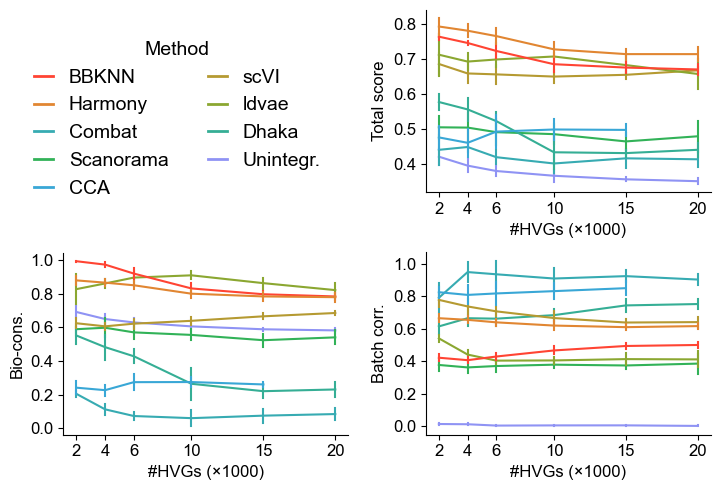

In [140]:
from matplotlib.lines import Line2D


font_config = {
    'axes.titlesize': 16,          # Title font size
    'axes.labelsize': 12,          # X and Y label font size
    'legend.title_fontsize': 14,   # Legend title font size
    'legend.fontsize': 14,         # Legend text font size
    'xtick.labelsize': 12,         # X-axis tick labels font size
    'ytick.labelsize': 12,         # Y-axis tick labels font size
}


with plt.rc_context(font_config):
    fig, axes = plt.subplots(2, 2)
    fig.set_size_inches(7.4, 5)
    for key, label, ax in zip(["Total", _BIO_CONSERVATION, _BATCH_INTEGRATION], ["Total score", "Bio-cons.", "Batch corr."], axes.flatten()[1:]):
        sns.lineplot(subset, x="#HVGs", y=key, hue="Method", ci='sd', err_style='bars', palette=method_colors, ax=ax, legend=False)
        ax.set_ylabel(label)
        ax.set_xlabel("#HVGs")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([2000, 4000, 6000, 10000, 15000, 20000])
        ax.set_xticklabels(['2', '4', '6', '10', '15', '20'])
        ax.set_xlabel("#HVGs (×1000)")
        #ax.set_yticks([0.2 * i for i in range(6)])
    handles = []
    for method in method_order:
        method = methods_map[method]
        handles.append(Line2D([0], [0], color=method_colors[method],label=method, linewidth=2.))
    ax4 = axes.flatten()[0]
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['bottom'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.set_xticks([])
    ax4.set_yticks([])

    # Place legend directly in the fourth axis
    ax4.legend(handles=handles, 
            loc='center',
            title="Method",
            bbox_to_anchor=(0.4, 0.4),
            frameon=False,
            ncols=2,
            handlelength=1.0
            )
    plt.tight_layout()
    fig.savefig("figures/n_hvgs.svg")

### Batch_key True vs False

In [142]:
results = get_results("../results/hvg_batch/eval/")

In [143]:
results = results.rename(index=methods_map)

In [144]:
cols = results.columns
g = results.groupby(level=[0, 1])[cols]
min_, max_ = g.transform('min'), g.transform('max')
results[cols] = (results[cols] - min_) / (max_ - min_)

In [145]:
results["Total"] = 0.6 * results[_BIO_COLS].mean(1) + 0.4 * results[_BATCH_COLS].mean(1)

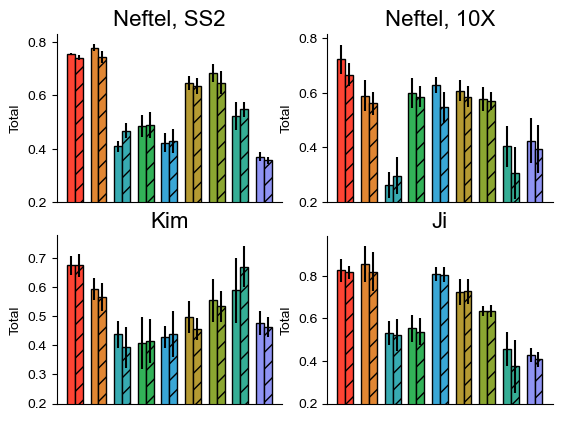

In [149]:
fig, axes = plt.subplots(2, 2, figsize=(6.4, 4.8))
with plt.rc_context(font_config):
    for dataset, ax in zip(dataset_map.keys(), axes.flatten()):

        subset = results[results.index.get_level_values(level=0)==dataset]
        subset = subset[["Total"]]
        subset = subset.reset_index().drop(["level_0", "level_1", "level_2"], axis=1)
        subset = subset.groupby(["level_3", "level_4"]).agg(['mean', 'std']) 
        

        y = []
        x = []
        err = []
        colors = []
        hatches = []
        
        bar_width = 0.1
        pos = 0
        for method in method_order:
            method = methods_map[method]
            for key in ["True", "False"]:
        
                y.append(subset.loc[(key, method), ("Total", "mean")])
                err.append(subset.loc[(key, method), ("Total", "std")])
                x.append(pos)
                hatches.append("" if key == "True" else "//")
                off_set = bar_width if key == "True" else bar_width + 0.1
                pos += off_set
                colors.append(method_colors[method])

        ax.bar(x, y, width=bar_width, color=colors, yerr=err, edgecolor='black', hatch=hatches)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(dataset_map[dataset])
        ax.set_ylabel("Total")
        ax.set_xticks([])
        ax.set_ylim((0.2, ax.get_ylim()[1]))

    handles = [mpatches.Patch(visible=False, label='Methods')]
    for method in method_order:
        method = methods_map[method]
        handles.append(mpatches.Patch( facecolor=method_colors[method],label=method))
    handles.append(mpatches.Patch(visible=False, label='Batch key'))
    for key, hatch in zip(["True", "False"], ["", "//"]):
        handles.append(mpatches.Patch( facecolor="lightgrey", hatch=hatch, label=key))


    #fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.9, 0.5))
    fig.savefig("figures/batch_key.svg", bbox_inches="tight")

## Suppl. Figure


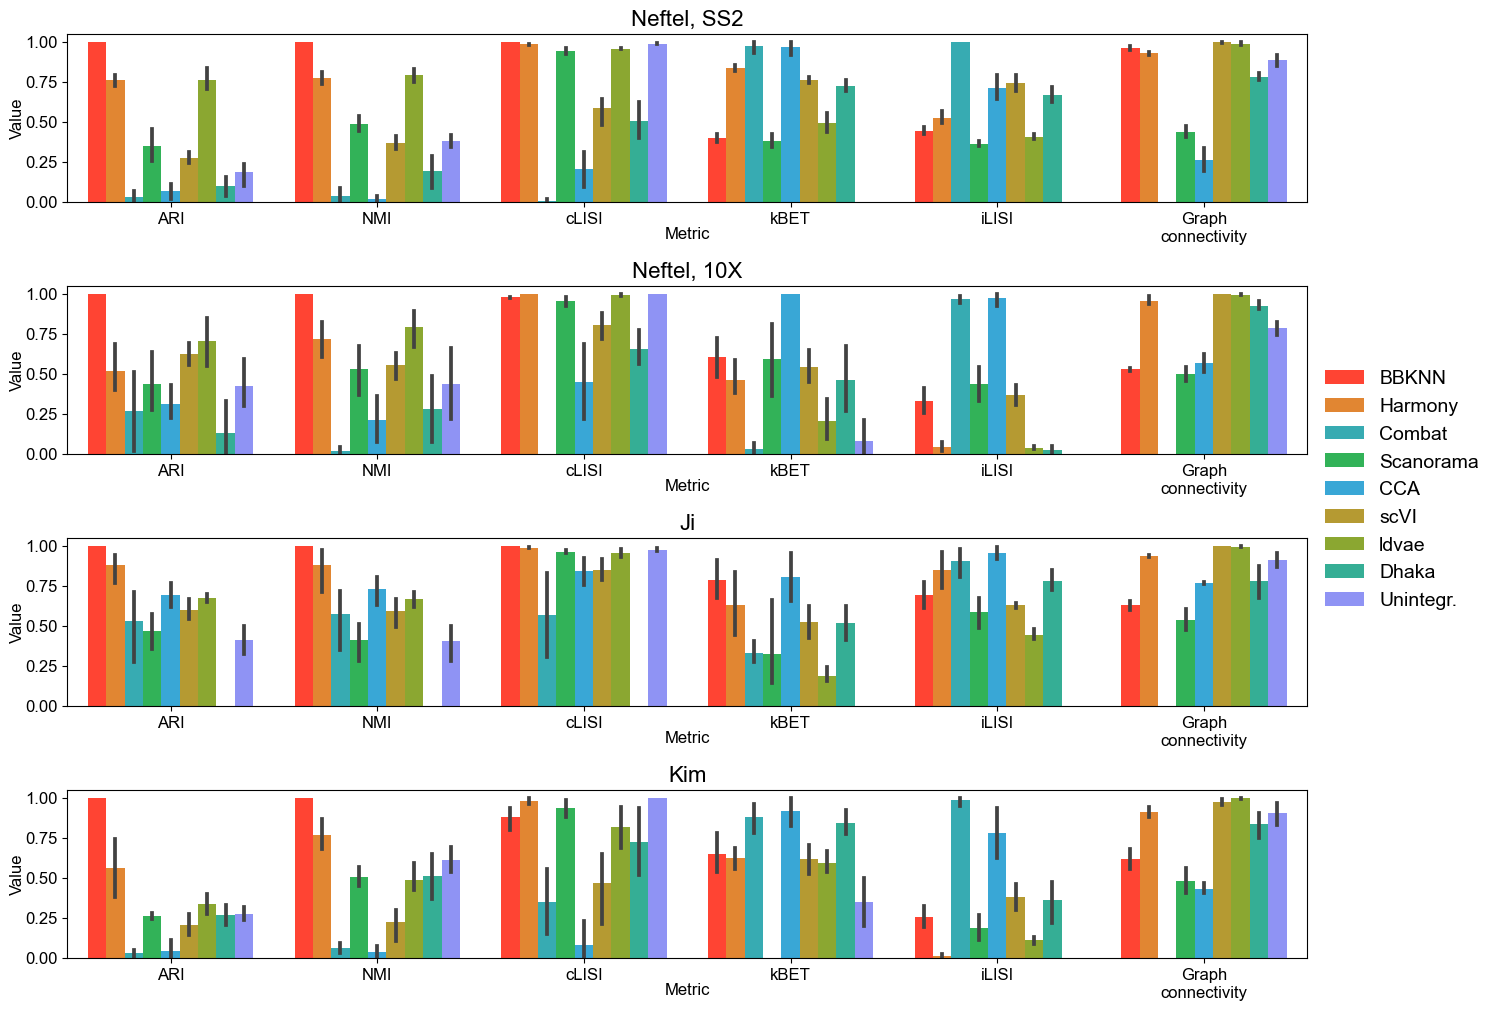

In [231]:
results = get_results("../results/benchmark/eval")

font_config = {
    'axes.titlesize': 16,          # Title font size
    'axes.labelsize': 12,          # X and Y label font size
    'legend.title_fontsize': 14,   # Legend title font size
    'legend.fontsize': 14,         # Legend text font size
    'xtick.labelsize': 12,         # X-axis tick labels font size
    'ytick.labelsize': 12,         # Y-axis tick labels font size
}

names = {
    "kbet_per_label": "kBET",
    "ilisis": "iLISI",
    "clisi": "cLISI",
    "graph_connect": "Graph\nconnectivity"
}

handles = []
with plt.rc_context(font_config):
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))

    for dataset, ax in zip(datasets, axes.flatten()):
        subset = results.loc[dataset]
        cols = subset.columns
        g = subset.groupby(level=[0])[cols]
        min_, max_ = g.transform('min'), g.transform('max')
        subset.loc[:, cols] = (subset[cols] - min_) / (max_ - min_)
        subset=subset.droplevel(level=[0, 1, 2])
        subset.index = subset.index.map(methods_map)
        
        subset["Method"] = subset.index

        subset = subset.rename(columns=names)

        sns.barplot(subset.melt(id_vars="Method", value_vars=["ARI", "NMI", "cLISI", "kBET", "iLISI", "Graph\nconnectivity"]), 
                    y="value", x="variable", hue="Method", 
                    hue_order=[methods[method] for method in method_order],
                    palette=method_colors,
                    saturation=1.,
                    ax=ax)
        ax.set_xlabel("Metric", labelpad=-12.5)
        ax.get_legend().remove()
        ax.set_yticks([1., 0.75, 0.5, 0.25, 0.])
        ax.set_ylabel("Value", labelpad=0.1)
        ax.set_title(dataset_map[dataset])
        
    for method in method_order:
        method = methods_map[method]
        handles.append(mpatches.Patch(facecolor=method_colors[method],label=method))
    fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.9, 0.5), frameon=False)
    fig.subplots_adjust(hspace=0.5)
    fig.savefig("figures/suppl_fig2.svg")